***


# Projet : Reed-Salomon, QR code et correction d’erreur
***
***


Jean-Loup Mellion  
Gatien Da Rocha

In [738]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import itertools
from collections import Counter

# Rappel interpolation polynomiale

Avant de s'attaquer a Reed-Salomon, il est important de rappeler le principe de l'interpolation polynomiale. L'interpolation polynomiale est une méthode mathématique permettant de trouver un polynôme qui passe par un ensemble de points donnés.

Pour cela, nous allons utiliser la méthode de Lagrange. Cette méthode permet de trouver un polynôme de degré n-1 passant par n points donnés.

### Polynôme de Lagrange

In [739]:
def polynome_base_lagrange(var_x: int, i: int, x_array: np.ndarray, y_array: np.ndarray) -> float:
    """
    Cette fonction calcule le polynome de base de lagrange, c'est à dire le produit des termes (x-x_j)/(x_i-x_j) pour j != i
    :param var_x: int, la valeur de x pour laquelle on veut calculer le polynome de base
    :param x_array: np.ndarray, les valeurs de x
    :param y_array: np.ndarray, les valeurs de y
    :param i: int, l'indice du polynome de base
    :return: float, le polynome de base de lagrange
    """
    res = 1
    for j in range(len(x_array)):
        if j != i:
            res = res * (var_x - x_array[j]) / (x_array[i] - x_array[j])
    return y_array[i]*res

In [740]:
def poly_lagrange(var_x: int, x_array: np.ndarray, y_array: np.ndarray) -> float:
    """
    Cette fonction calcule le polynome de lagrange pour un x donné, c'est à dire la somme des polynomes de base de lagrange
    :param var_x: int, la valeur de x pour laquelle on veut calculer le polynome de lagrange
    :param x_array: np.ndarray, les valeurs de x
    :param y_array: np.ndarray, les valeurs de y
    """
    sum = 0
    for i in range(len(x_array)):
        sum = sum + polynome_base_lagrange(var_x, i, x_array, y_array)
    return sum

Nous allons maintenant tester la méthode de Lagrange sur un exemple simple.

In [741]:
# On défnit le message à envoyer
message_original = [6, 9, 4, 2, 0]

# On encode le message
def encode_message(message: list, t: int) -> tuple:
    """
    Cette fonction encode un message en rajoutant de la redondance pour pouvoir corriger des erreurs
    :param message: list, le message à encoder
    :param t: int, le nombre d'erreurs que l'on veut pouvoir corriger
    :return: tuple, les valeurs de x et de y
    """
    x_array = []
    for i in range(len(message)):
        x_array.append(i+1)

    y_array = message
    for i in range(t):
        y_array.append(poly_lagrange(len(x_array)+i+1, np.array(x_array), np.array(message)))

    for i in range(t):
        x_array.append(len(x_array)+1)
    return x_array, y_array

x_array, y_array = encode_message(message_original, 2)

print("x_array:", x_array)
print("y_array:", y_array)

x_array: [1, 2, 3, 4, 5, 6, 7]
y_array: [6, 9, 4, 2, 0, -19.0, -86.0]


In [742]:
# Ensuite on peut retirer 1 ou 2 valeurs du message pour simuler des erreurs
message_erreur = y_array.copy()
message_erreur[0] = 0

print("message_erreur:", message_erreur)

def detect_erreur(k: int, y_array: list) -> bool:
    """
    Cette fonction détecte si il y a une erreur dans le message
    :param k: int, le nombre de valeurs à retirer du message
    :param y_array: list, les valeurs de y
    :return: bool, True si il y a une erreur, False sinon
    """
    y_array = np.asarray(y_array)
    xt = np.arange(len(y_array))
    list_s = list(itertools.combinations(xt, k))
    res = []
    erreur = False
    print("y_array:", y_array)
    print("list_s:", list_s)
    for s in list_s:
        s = list(s)
        resPol = list(poly_lagrange(xt,s,y_array[s]))
        if resPol not in res:
            res.append(resPol)
    if len(res) > 1:
        erreur = True
    return erreur

def correct_message(k: int, y_array: np.ndarray) -> list:
    """
    Cette fonction corrige un message
    :param k: int, 
    :param y_array: np.ndarray, les valeurs de y
    """
    y_array = np.asarray(y_array)
    erreur = detect_erreur(k, y_array)
    if erreur:
        res_map = Counter()
        combinaison = itertools.combinations(range(len(y_array)), k)
        for c in combinaison:
            c = list(c)
            pol = []
            for i in range(k):
                pol.append(poly_lagrange(i, c, y_array[c]))
            res_map[tuple(pol)] += 1
        most_common = res_map.most_common(1)[0][0]
        return most_common
    return y_array

corrected_message = correct_message(5, message_erreur)
print("corrected_message:", corrected_message)

message_erreur: [0, 9, 4, 2, 0, -19.0, -86.0]
y_array: [  0.   9.   4.   2.   0. -19. -86.]
list_s: [(0, 1, 2, 3, 4), (0, 1, 2, 3, 5), (0, 1, 2, 3, 6), (0, 1, 2, 4, 5), (0, 1, 2, 4, 6), (0, 1, 2, 5, 6), (0, 1, 3, 4, 5), (0, 1, 3, 4, 6), (0, 1, 3, 5, 6), (0, 1, 4, 5, 6), (0, 2, 3, 4, 5), (0, 2, 3, 4, 6), (0, 2, 3, 5, 6), (0, 2, 4, 5, 6), (0, 3, 4, 5, 6), (1, 2, 3, 4, 5), (1, 2, 3, 4, 6), (1, 2, 3, 5, 6), (1, 2, 4, 5, 6), (1, 3, 4, 5, 6), (2, 3, 4, 5, 6)]
corrected_message: (6.0, 9.0, 4.0, 2.0, 0.0)


# Reed-Salomon

Le principale problème de l'interpolation polynomiale avec les messages codés c'est que les y des points de redondances peuvent être bien trop grand, par exemple si on veux encoder un message avec que 1 octet par point, y doit etre compris entre 0 et 255, mais un point de redondance peut être bien plus grand que 255. Pour résoudre ce problème, on utilise le code de Reed-Salomon, qui limite la taille des y a l'aide de modulo.

Video explicative : https://www.youtube.com/watch?v=1pQJkt7-R4Q

### Gestion des erreurs python

Comme il y a beaucoup d'endroit ou une erreur peut se produire, on va utiliser des exceptions pour les gérer. On va donc créer une classe d'exception pour les erreurs de Reed-Salomon.

In [743]:
class ReedSolomonError(Exception):
    """
    Cette classe permet de gérer les erreurs dans le code Reed-Solomon
    """
    pass

### Initialisation de la table de Galois

Implémenté à partir de : https://en.wikiversity.org/wiki/Reed%E2%80%93Solomon_codes_for_coders#Multiplication_with_logarithms, et d'autres sources.

In [744]:
# On a besoin de multiplier des nombres dans un champ de Galois pour initialiser les tables
def gf_mult_noLUT(x: int, y: int, prim: int = 0) -> int:
    """
    Multiplication dans le champ de Galois sans table de recherche (LUT).

    :param x: int, premier opérande
    :param y: int, deuxième opérande
    :param prim: int, polynôme primitif
    :return: int, résultat de la multiplication
    """
    def cl_mult(x: int, y: int) -> int:
        z = 0
        i = 0
        while (y >> i) > 0:
            if y & (1 << i):
                z ^= x << i
            i += 1
        return z

    def bit_length(n: int) -> int:
        bits = 0
        while n >> bits: 
            bits += 1
        return bits

    def cl_div(dividend: int, divisor: int = None) -> int:
        dl1 = bit_length(dividend)
        dl2 = bit_length(divisor)
        if dl1 < dl2:
            return dividend
        for i in range(dl1 - dl2, -1, -1):
            if dividend & (1 << (i + dl2 - 1)):
                dividend ^= divisor << i
        return dividend

    result = cl_mult(x, y)
    if prim > 0:
        result = cl_div(result, prim)
    return result

gf_exp = [0] * 512
gf_log = [0] * 256

# On initialise les tables de logarithme et d'exponentiation pour les opérations dans le champ de Galois
def init_tables(prim: int = 0x11d) -> list[list[int]]:
    """
    Initialisation des tables logarithmique et exponentielle pour le champ de Galois.

    :param prim: int, polynôme primitif
    :return: list[list[int]], tables logarithmique et exponentielle
    """
    global gf_exp, gf_log
    gf_exp = [0] * 512
    gf_log = [0] * 256
    x = 1
    for i in range(255):
        gf_exp[i] = x
        gf_log[x] = i
        x = gf_mult_noLUT(x, 2, prim)
    for i in range(255, 512):
        gf_exp[i] = gf_exp[i - 255]
    return [gf_log, gf_exp]

### Operations sur GF(field_size)

Implémenté à partir de : https://en.wikiversity.org/wiki/Reed%E2%80%93Solomon_codes_for_coders#Finite_field_arithmetic, et d'autres sources.

On implémente pas les additions et soustractions car on peut les faire simplement avec les opérations XOR. (a+b = a^b)

In [745]:
# Multiplication plus rapide avec les tables de logarithme et d'exponentiation
def gf_mul(x: int, y: int) -> int:
    """
    Multiplication dans le champ de Galois avec tables de recherche (LUT).

    :param x: int, premier opérande
    :param y: int, deuxième opérande
    :return: int, résultat de la multiplication
    """
    if x == 0 or y == 0:
        return 0
    return gf_exp[gf_log[x] + gf_log[y]]

def gf_div(x: int, y: int) -> int:
    """
    Division dans le champ de Galois.

    :param x: int, numérateur
    :param y: int, dénominateur
    :return: int, résultat de la division
    :raises ZeroDivisionError: si y est zéro
    """
    if y == 0:
        raise ZeroDivisionError()
    if x == 0:
        return 0
    return gf_exp[(gf_log[x] + 255 - gf_log[y]) % 255]

def gf_pow(x: int, power: int) -> int:
    """
    Exponentiation dans le champ de Galois.

    :param x: int, base
    :param power: int, exposant
    :return: int, résultat de l'exponentiation
    """
    return gf_exp[(gf_log[x] * power) % 255]

def gf_inverse(x: int) -> int:
    """
    Inverse dans le champ de Galois.

    :param x: int, élément dont on veut l'inverse
    :return: int, inverse de x
    """
    return gf_exp[255 - gf_log[x]]

def gf_poly_scale(p: list[int], x: int) -> list[int]:
    """
    Multiplication d'un polynôme par un scalaire dans le champ de Galois.

    :param p: list[int], polynôme
    :param x: int, scalaire
    :return: list[int], polynôme résultant
    """
    return [gf_mul(p[i], x) for i in range(len(p))]

def gf_poly_add(p: list[int], q: list[int]) -> list[int]:
    """
    Addition de deux polynômes dans le champ de Galois.

    :param p: list[int], premier polynôme
    :param q: list[int], deuxième polynôme
    :return: list[int], polynôme résultant
    """
    r = [0] * max(len(p), len(q))
    for i in range(len(p)):
        r[i + len(r) - len(p)] = p[i]
    for i in range(len(q)):
        r[i + len(r) - len(q)] ^= q[i]
    return r

def gf_poly_mul(p: list[int], q: list[int]) -> list[int]:
    """
    Multiplication de deux polynômes dans le champ de Galois.

    :param p: list[int], premier polynôme
    :param q: list[int], deuxième polynôme
    :return: list[int], polynôme résultant
    """
    r = [0] * (len(p) + len(q) - 1)
    for j in range(len(q)):
        for i in range(len(p)):
            r[i + j] ^= gf_mul(p[i], q[j])
    return r

def gf_poly_div(dividend: list[int], divisor: list[int]) -> tuple[list[int], list[int]]:
    """
    Division de deux polynômes dans le champ de Galois.

    :param dividend: list[int], polynôme dividende
    :param divisor: list[int], polynôme diviseur
    :return: tuple[list[int], list[int]], quotient et reste de la division
    """
    msg_out = list(dividend)
    for i in range(len(dividend) - (len(divisor) - 1)):
        coef = msg_out[i]
        if coef != 0:
            for j in range(1, len(divisor)):
                if divisor[j] != 0:
                    msg_out[i + j] ^= gf_mul(divisor[j], coef)
    separator = -(len(divisor) - 1)
    return msg_out[:separator], msg_out[separator:]

def gf_poly_eval(poly: list[int], x: int) -> int:
    """
    Évaluation d'un polynôme dans le champ de Galois à une valeur donnée.

    :param poly: list[int], polynôme
    :param x: int, valeur d'évaluation
    :return: int, résultat de l'évaluation
    """
    y = poly[0]
    for i in range(1, len(poly)):
        y = gf_mul(y, x) ^ poly[i]
    return y

In [746]:
# Tests pour les opérations sur GF(2^8) 
def test_gf_operations():
    """
    Cette fonction teste les opérations sur GF(2^8)
    Validé avec https://hp.vector.co.jp/authors/VA021385/galois_calc.htm
    """
    
    # Multiplication
    assert gf_mul(15, 27) == 153
    assert gf_mul(0, 15) == 0
    assert gf_mul(15, 0) == 0
    assert gf_mul(15, 1) == 15
    assert gf_mul(42, 69) == 208
    
    # Division
    assert gf_div(188, 15) == 216
    assert gf_div(188, 1) == 188
    assert gf_div(15, 188) == 16
    assert gf_div(42, 69) == 227
    assert gf_div(69, 42) == 240
    
    # Puissance
    assert gf_pow(15, 0) == 1
    assert gf_pow(15, 1) == 15
    assert gf_pow(15, 2) == 85
    assert gf_pow(15, 3) == 36
    assert gf_pow(42, 69) == 208
    
    # Inversion
    assert gf_inverse(15) == 150

    print("Tous les tests passent")

init_tables()
test_gf_operations()

Tous les tests passent


### Encodage

In [747]:
def rs_generator_poly(nsym: int) -> list[int]:
    """
    Génération du polynôme générateur pour le code de Reed-Solomon.

    :param nsym: int, nombre de symboles de correction d'erreur
    :return: list[int], polynôme générateur
    """
    g = [1]
    for i in range(nsym):
        g = gf_poly_mul(g, [1, gf_pow(2, i)])
    return g

def rs_encode_msg(msg_in: list[int], nsym: int) -> list[int]:
    """
    Encodage d'un message avec le code de Reed-Solomon.

    :param msg_in: list[int], message à encoder
    :param nsym: int, nombre de symboles de correction d'erreur
    :return: list[int], message encodé
    :raises ValueError: si le message est trop long
    """
    if len(msg_in) + nsym > 255:
        raise ValueError("Le message est trop long")
    gen = rs_generator_poly(nsym)
    msg_out = [0] * (len(msg_in) + len(gen) - 1)
    msg_out[:len(msg_in)] = msg_in

    for i in range(len(msg_in)):
        coef = msg_out[i]
        if coef != 0:
            for j in range(1, len(gen)):
                msg_out[i + j] ^= gf_mul(gen[j], coef)

    msg_out[:len(msg_in)] = msg_in
    return msg_out

### Decodage (correction d'erreurs)

In [748]:
def rs_calc_syndromes(msg: list[int], nsym: int) -> list[int]:
    """
    Calcul des syndromes pour le code de Reed-Solomon.

    :param msg: list[int], message encodé
    :param nsym: int, nombre de symboles de correction d'erreur
    :return: list[int], syndromes
    """
    synd = [0] * nsym
    for i in range(nsym):
        synd[i] = gf_poly_eval(msg, gf_pow(2, i))
    return [0] + synd

def rs_find_errata_locator(e_pos: list[int]) -> list[int]:
    """
    Trouver le localisateur d'erreurs pour le code de Reed-Solomon.

    :param e_pos: list[int], positions des erreurs
    :return: list[int], polynôme localisateur d'erreurs
    """
    e_loc = [1]
    for i in e_pos:
        e_loc = gf_poly_mul(e_loc, gf_poly_add([1], [gf_pow(2, i), 0]))
    return e_loc

def rs_find_error_evaluator(synd: list[int], err_loc: list[int], nsym: int) -> list[int]:
    """
    Trouver l'évaluateur d'erreurs pour le code de Reed-Solomon.

    :param synd: list[int], syndromes
    :param err_loc: list[int], localisateur d'erreurs
    :param nsym: int, nombre de symboles de correction d'erreur
    :return: list[int], évaluateur d'erreurs
    """
    _, remainder = gf_poly_div(gf_poly_mul(synd, err_loc), ([1] + [0] * (nsym + 1)))
    return remainder

def rs_correct_errata(msg_in: list[int], synd: list[int], err_pos: list[int]) -> list[int]:
    """
    Correction des erreurs dans le message pour le code de Reed-Solomon.

    :param msg_in: list[int], message encodé avec erreurs
    :param synd: list[int], syndromes
    :param err_pos: list[int], positions des erreurs
    :return: list[int], message corrigé
    :raises ReedSolomonError: si une erreur de magnitude ne peut pas être trouvée
    """
    coef_pos = [len(msg_in) - 1 - p for p in err_pos]
    err_loc = rs_find_errata_locator(coef_pos)
    err_eval = rs_find_error_evaluator(synd[::-1], err_loc, len(err_loc) - 1)[::-1]

    X = []
    for i in range(len(coef_pos)):
        l = 255 - coef_pos[i]
        X.append(gf_pow(2, -l))

    E = [0] * len(msg_in)
    Xlength = len(X)
    for i, Xi in enumerate(X):
        Xi_inv = gf_inverse(Xi)
        err_loc_prime_tmp = []
        for j in range(Xlength):
            if j != i:
                err_loc_prime_tmp.append(1 ^ gf_mul(Xi_inv, X[j]))
        err_loc_prime = 1
        for coef in err_loc_prime_tmp:
            err_loc_prime = gf_mul(err_loc_prime, coef)

        y = gf_poly_eval(err_eval[::-1], Xi_inv)
        y = gf_mul(gf_pow(Xi, 1), y)

        if err_loc_prime == 0:
            raise ReedSolomonError("Impossible de trouver la magnitude de l'erreur")

        magnitude = gf_div(y, err_loc_prime)
        E[err_pos[i]] = magnitude

    msg_in = gf_poly_add(msg_in, E)
    return msg_in

def rs_find_error_locator(synd: list[int], nsym: int, erase_loc: list[int] | None = None, erase_count: int = 0) -> list[int]:
    """
    Trouver le localisateur d'erreurs pour le code de Reed-Solomon avec gestion des effacements.

    :param synd: list[int], syndromes
    :param nsym: int, nombre de symboles de correction d'erreur
    :param erase_loc: list[int] | None, localisateur d'effacements
    :param erase_count: int, nombre d'effacements
    :return: list[int], localisateur d'erreurs
    :raises ReedSolomonError: si trop d'erreurs à corriger
    """
    if erase_loc:
        err_loc = list(erase_loc)
        old_loc = list(erase_loc)
    else:
        err_loc = [1]
        old_loc = [1]

    synd_shift = len(synd) - nsym

    for i in range(nsym - erase_count):
        if erase_loc:
            K = erase_count + i + synd_shift
        else:
            K = i + synd_shift

        delta = synd[K]
        for j in range(1, len(err_loc)):
            delta ^= gf_mul(err_loc[-(j + 1)], synd[K - j])

        old_loc = old_loc + [0]

        if delta != 0:
            if len(old_loc) > len(err_loc):
                new_loc = gf_poly_scale(old_loc, delta)
                old_loc = gf_poly_scale(err_loc, gf_inverse(delta))
                err_loc = new_loc

            err_loc = gf_poly_add(err_loc, gf_poly_scale(old_loc, delta))

    while len(err_loc) and err_loc[0] == 0:
        del err_loc[0]

    errs = len(err_loc) - 1
    if (errs - erase_count) * 2 + erase_count > nsym:
        raise ReedSolomonError("Trop d'erreurs à corriger")
    return err_loc

def rs_find_errors(err_loc: list[int], nmess: int) -> list[int]:
    """
    Trouver les erreurs dans le message pour le code de Reed-Solomon.

    :param err_loc: list[int], localisateur d'erreurs
    :param nmess: int, taille du message
    :return: list[int], positions des erreurs
    :raises ReedSolomonError: si trop d'erreurs trouvées
    """
    errs = len(err_loc) - 1
    err_pos = []
    for i in range(nmess):
        if gf_poly_eval(err_loc, gf_pow(2, i)) == 0:
            err_pos.append(nmess - 1 - i)
    if len(err_pos) != errs:
        raise ReedSolomonError("Trop (ou pas assez) d'erreurs trouvées par la recherche de Chien pour le polynôme localisateur d'erreurs !")
    return err_pos

def rs_forney_syndromes(synd: list[int], pos: list[int], nmess: int) -> list[int]:
    """
    Calcul des syndromes de Forney pour le code de Reed-Solomon.

    :param synd: list[int], syndromes
    :param pos: list[int], positions des erreurs
    :param nmess: int, taille du message
    :return: list[int], syndromes de Forney
    """
    erase_pos_reversed = [nmess - 1 - p for p in pos]
    fsynd = list(synd[1:])
    for i in range(len(pos)):
        x = gf_pow(2, erase_pos_reversed[i])
        for j in range(len(fsynd) - 1):
            fsynd[j] = gf_mul(fsynd[j], x) ^ fsynd[j + 1]
    return fsynd

def rs_correct_msg(msg_in: list[int], nsym: int, erase_pos: list[int] | None = None) -> tuple[list[int], list[int]]:
    """
    Correction d'un message encodé avec le code de Reed-Solomon.

    :param msg_in: list[int], message encodé avec erreurs
    :param nsym: int, nombre de symboles de correction d'erreur
    :param erase_pos: list[int] | None, positions des effacements
    :return: tuple[list[int], list[int]], message corrigé et code de correction
    :raises ValueError: si le message est trop long
    :raises ReedSolomonError: si le message ne peut pas être corrigé
    """
    if len(msg_in) > 255:
        raise ValueError("Le message est trop long")

    msg_out = list(msg_in)
    if erase_pos is None:
        erase_pos = []
    else:
        for e_pos in erase_pos:
            msg_out[e_pos] = 0
    if len(erase_pos) > nsym:
        raise ReedSolomonError("Trop d'effacements à corriger")

    synd = rs_calc_syndromes(msg_out, nsym)
    if max(synd) == 0:
        return msg_out[:-nsym], msg_out[-nsym:]

    fsynd = rs_forney_syndromes(synd, erase_pos, len(msg_out))
    err_loc = rs_find_error_locator(fsynd, nsym, erase_count=len(erase_pos))
    err_pos = rs_find_errors(err_loc[::-1], len(msg_out))
    if err_pos is None:
        raise ReedSolomonError("Impossible de localiser l'erreur")

    msg_out = rs_correct_errata(msg_out, synd, erase_pos + err_pos)
    synd = rs_calc_syndromes(msg_out, nsym)
    if max(synd) > 0:
        raise ReedSolomonError("Impossible de corriger le message")
    return msg_out[:-nsym], msg_out[-nsym:]

### Test complet

In [749]:
n = 20 # longueur du message avec redondance
k = 11 # longueur du message original
message_original = "hello world"
print("Message original: %s" % message_original)

init_tables()

message_encode = rs_encode_msg([ord(x) for x in message_original], n - k)
print("Original encodé: %s" % message_encode)

message_encode[0] = 0
message_encode[1] = 2
message_encode[2] = 2
message_encode[3] = 2
message_encode[4] = 2
message_encode[5] = 2
print("Message corrompu: %s" % message_encode)

corrected_message, corrected_ecc = rs_correct_msg(message_encode, n - k, erase_pos=[0, 1, 2])
print("Message corrigé encodé: %s" % corrected_message)
print("Message corrigé:", ''.join([chr(x) for x in corrected_message]))

Message original: hello world
Original encodé: [104, 101, 108, 108, 111, 32, 119, 111, 114, 108, 100, 145, 124, 96, 105, 94, 31, 179, 149, 163]
Message corrompu: [0, 2, 2, 2, 2, 2, 119, 111, 114, 108, 100, 145, 124, 96, 105, 94, 31, 179, 149, 163]
Message corrigé encodé: [104, 101, 108, 108, 111, 32, 119, 111, 114, 108, 100]
Message corrigé: hello world


# Application dans les QR codes et autres en correction d'erreur

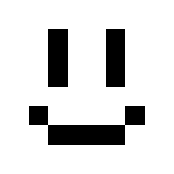

In [750]:
def draw_qr_code(array: np.ndarray, pixel_size: int = 2):
    """
    Cette fonction dessine un tableau 2D de booléens
    :param array: np.ndarray, le tableau 2D de booléens
    :param pixel_size: int, la taille d'un pixel
    """
    array = np.logical_not(array)
    plt.figure(figsize=(array.shape[1]*pixel_size/array.shape[0], pixel_size))
    plt.imshow(array, cmap='gray')
    plt.axis('off')
    plt.show()

array = [
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 1, 0],
    [0, 0, 1, 1, 1, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
]

array = np.array(array, dtype=bool)
draw_qr_code(array)

### Structure d'un QR code

Les QR codes ont une structure bien précise, avec des zones de calibrage, des zones de format, des zones de timing, des zones de données, des zones de correction d'erreur, etc.

![QR code](qr-code-structure.png)

Ici, nous allons seulement nous intéresser aux zones de données et de correction d'erreur. (version 1 21x21)

![QR code](qr-code-pattern.png)

Et pour simplifier on va suivre une structure bien plus simple, avec seulement des blocs de 2x4 bits.

x_array: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
y_array: [12, 0, 72, 101, 108, 108, 111, 32, 87, 111, 114, 108, 100, 33, 20, 43, 10, 80, 241, 13, 223, 75]


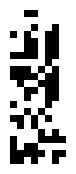

In [751]:
def encode_message(message: str, t: int) -> np.ndarray:
    """
    This function encodes a message by adding redundancy and converting it to a 2D array of booleans.
    :param message: str, the message to encode
    :param t: int, the number of errors we want to be able to correct
    :return: np.ndarray, the encoded message as a 2D array
    """
    # Encode the message length and message in ASCII
    message_length = len(message)
    length_encoded = message_length.to_bytes(2, byteorder='little')
    message_encoded = message.encode('ascii')
    
    # Combine the length and message
    combined_message = length_encoded + message_encoded
    
    # Convert the combined message to a numpy array of uint8
    message_array = np.frombuffer(combined_message, dtype=np.uint8)
    
    # Assume encode_message_rs is defined elsewhere and returns two arrays
    x_array, y_array = encode_message_rs(message_array.tolist(), t)
    print("x_array:", x_array)
    print("y_array:", y_array)
    
    # Create a 2D boolean array initialized to zeros
    array = np.zeros((len(y_array), 8), dtype=bool)
    
    # Populate the 2D array with bits from the x_array
    for i in range(len(y_array)):
        for j in range(8):
            array[i][j] = (y_array[i] >> j) & 1
    
    return array, y_array

# Example usage
encoded_message, original_y_array = encode_message("Hello World!", 4)
draw_qr_code(encoded_message)

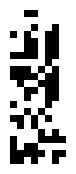

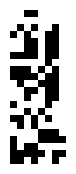

In [752]:
# Ajoute des erreurs random dans le message
def add_errors(array: np.ndarray, t: int) -> np.ndarray:
    """
    Cette fonction ajoute des erreurs aléatoires dans le message
    :param array: np.ndarray, le message à encoder
    :param t: int, le nombre d'erreurs à ajouter
    :return: np.ndarray, le message avec des erreurs
    """
    # Copy the array to avoid modifying the original
    array = array.copy()
    
    # Generate random indices for errors
    indices = np.random.choice(array.size, t, replace=False)
    
    # Add errors
    for index in indices:
        array[index // 8][index % 8] ^= 1
    
    return array

corrupted_message = add_errors(encoded_message, 2)
draw_qr_code(encoded_message)
draw_qr_code(corrupted_message)

In [753]:
def decode_message(encoded_array: np.ndarray, t: int) -> str:
    """
    This function decodes a message from a 2D array of booleans, correcting errors.
    :param encoded_array: np.ndarray, the encoded message as a 2D array of booleans
    :param t: int, the number of errors we want to be able to correct
    :return: str, the decoded message
    """
    # Convert the 2D boolean array back to a 1D array of bytes
    y_array = []
    for row in encoded_array:
        byte = 0
        for j in range(8):
            if row[j]:
                byte |= (1 << j)
        y_array.append(byte)

    # Make the x_array
    x_array = []
    for i in range(len(y_array)):
        x_array.append(i+1)
    print("x_array:", x_array)

    print("y_array:", y_array)

    # Assume localiser_erreurs_rs and corriger_erreurs_rs are defined elsewhere
    erreurs = localiser_erreurs_rs(y_array, t)
    print("erreurs:", erreurs)
    y_array = corriger_erreurs_rs(x_array, y_array, y_array, erreurs)
    print("y_array corrigé:", y_array)
    print("y_array original:", original_y_array)

    # Convert the corrected y_array to a bytes object
    corrected_message = bytes(y_array)

    # Decode the message
    message_length = int.from_bytes(corrected_message[:2], byteorder='big')
    message = corrected_message[2:2+message_length].decode('ascii')
    return message

message_original = decode_message(corrupted_message, 2)
print(message_original)

x_array: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
y_array: [12, 0, 74, 101, 108, 108, 111, 32, 87, 111, 114, 108, 100, 33, 20, 43, 10, 112, 241, 13, 223, 75]


NameError: name 'localiser_erreurs_rs' is not defined